<a href="https://colab.research.google.com/github/HanjunHeatherLi/Clinical_no_show_project/blob/main/project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 

     | 38.3MB 648kB/s
     |████████████████████████████████| 81kB 3.9MB/s 
     |████████████████████████████████| 1.1MB 10.2MB/s 
     |████████████████████████████████| 3.2MB 18.2MB/s 
     |████████████████████████████████| 61kB 6.0MB/s 
     |████████████████████████████████| 81kB 7.0MB/s 
     |████████████████████████████████| 296kB 37.9MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.12.0-py2.py3-none-any.whl size=243829 sha256=7e1f269825a0cc6031884f479af743fd90e6ba69811ebaed407ebf3ab8e75f4a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ks0f2idt/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp37-none-any.whl size=27085 sha256=d30736199364d643a638c1ab031aab74455e8b5a828031120d5e8019e1ee1288
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
  Created wheel for phik: filename=phik-0.11.2-cp37-none-any.whl size=1107413 sha256=

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from pandas_profiling import ProfileReport 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_val_score
from matplotlib.legend_handler import HandlerLine2D
from sklearn.metrics import accuracy_score

In [3]:
workingpath = "/content/drive/MyDrive/Colab Notebooks/project/" 

#Data loading section

In [4]:
df=pd.read_csv( workingpath + "KaggleV2_May_2016.csv")
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589980e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262960e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679510e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841190e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


# data clean up

##check duplicate and na

In [5]:
df.duplicated().any()

False

In [6]:
df.isnull().values.any()


False

In [7]:
df[df.Age==-1].shape[0]

1

In [8]:
df['Handcap'].value_counts()

0    108286
1      2042
2       183
3        13
4         3
Name: Handcap, dtype: int64

In [9]:
df = df[df.Age >= 0]

In [10]:
df.shape

(110526, 14)

##remove patient&appointment ID


In [11]:
df.drop(['PatientId','AppointmentID'],axis=1,inplace=True)


In [12]:
df.AppointmentDay=pd.to_datetime(df.AppointmentDay)
df.ScheduledDay=pd.to_datetime(df.ScheduledDay)
df['daystoappoint']=(df.AppointmentDay-df.ScheduledDay).dt.days+1
df.drop(['ScheduledDay','AppointmentDay'],axis=1,inplace=True)


##make dummy variables

###gender

In [13]:
le=LabelEncoder()
df['Gender']=le.fit_transform(df['Gender']) # 0 is famale 1 is male

###Neighbourhood

In [14]:
n = len(pd.unique(df['Neighbourhood']))
n

81

In [15]:
dummy=pd.get_dummies(df.Neighbourhood, prefix='NB')
df=df.merge(dummy, how='outer', left_index=True, right_index=True)
df.drop(['Neighbourhood'],axis=1,inplace=True)


In [16]:
dummy=pd.get_dummies(df.Handcap, prefix='Hcap')
df=df.merge(dummy, how='outer', left_index=True, right_index=True)
df.drop(['Handcap'],axis=1,inplace=True)


###dependent variable No_show to 0 or 1

In [40]:
df['No-show'] = le.fit_transform(df['No-show'])# 0=no 1=yes
df.head(10)

,No-show,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,daystoappoint,NB_AEROPORTO,NB_ANDORINHAS,NB_ANTÔNIO HONÓRIO,NB_ARIOVALDO FAVALESSA,NB_BARRO VERMELHO,NB_BELA VISTA,NB_BENTO FERREIRA,NB_BOA VISTA,NB_BONFIM,NB_CARATOÍRA,NB_CENTRO,NB_COMDUSA,NB_CONQUISTA,NB_CONSOLAÇÃO,NB_CRUZAMENTO,NB_DA PENHA,NB_DE LOURDES,NB_DO CABRAL,NB_DO MOSCOSO,NB_DO QUADRO,NB_ENSEADA DO SUÁ,NB_ESTRELINHA,NB_FONTE GRANDE,NB_FORTE SÃO JOÃO,NB_FRADINHOS,NB_GOIABEIRAS,NB_GRANDE VITÓRIA,NB_GURIGICA,NB_HORTO,NB_ILHA DAS CAIEIRAS,NB_ILHA DE SANTA MARIA,...,NB_MONTE BELO,NB_MORADA DE CAMBURI,NB_MÁRIO CYPRESTE,NB_NAZARETH,NB_NOVA PALESTINA,NB_PARQUE INDUSTRIAL,NB_PARQUE MOSCOSO,NB_PIEDADE,NB_PONTAL DE CAMBURI,NB_PRAIA DO CANTO,NB_PRAIA DO SUÁ,NB_REDENÇÃO,NB_REPÚBLICA,NB_RESISTÊNCIA,NB_ROMÃO,NB_SANTA CECÍLIA,NB_SANTA CLARA,NB_SANTA HELENA,NB_SANTA LUÍZA,NB_SANTA LÚCIA,NB_SANTA MARTHA,NB_SANTA TEREZA,NB_SANTO ANDRÉ,NB_SANTO ANTÔNIO,NB_SANTOS DUMONT,NB_SANTOS REIS,NB_SEGURANÇA DO LAR,NB_SOLON BORGES,NB_SÃO BENEDITO,NB_SÃO CRISTÓVÃO,NB_SÃO JOSÉ,NB_SÃO PEDRO,NB_TABUAZEIRO,NB_UNIVERSITÁRIO,NB_VILA RUBIM,Hcap_0,Hcap_1,Hcap_2,Hcap_3,Hcap_4
0,0,0,62,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,1,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,56,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,76,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,1,0,23,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7,1,0,39,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
8,0,0,21,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
9,0,0,19,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


##Organize dataframe

###put the dependent variable to the front

In [18]:
col_name="No-show"
first_col = df.pop(col_name)
df.insert(0, col_name, first_col)
df.head()

,No-show,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,daystoappoint,NB_AEROPORTO,NB_ANDORINHAS,NB_ANTÔNIO HONÓRIO,NB_ARIOVALDO FAVALESSA,NB_BARRO VERMELHO,NB_BELA VISTA,NB_BENTO FERREIRA,NB_BOA VISTA,NB_BONFIM,NB_CARATOÍRA,NB_CENTRO,NB_COMDUSA,NB_CONQUISTA,NB_CONSOLAÇÃO,NB_CRUZAMENTO,NB_DA PENHA,NB_DE LOURDES,NB_DO CABRAL,NB_DO MOSCOSO,NB_DO QUADRO,NB_ENSEADA DO SUÁ,NB_ESTRELINHA,NB_FONTE GRANDE,NB_FORTE SÃO JOÃO,NB_FRADINHOS,NB_GOIABEIRAS,NB_GRANDE VITÓRIA,NB_GURIGICA,NB_HORTO,NB_ILHA DAS CAIEIRAS,NB_ILHA DE SANTA MARIA,...,NB_MONTE BELO,NB_MORADA DE CAMBURI,NB_MÁRIO CYPRESTE,NB_NAZARETH,NB_NOVA PALESTINA,NB_PARQUE INDUSTRIAL,NB_PARQUE MOSCOSO,NB_PIEDADE,NB_PONTAL DE CAMBURI,NB_PRAIA DO CANTO,NB_PRAIA DO SUÁ,NB_REDENÇÃO,NB_REPÚBLICA,NB_RESISTÊNCIA,NB_ROMÃO,NB_SANTA CECÍLIA,NB_SANTA CLARA,NB_SANTA HELENA,NB_SANTA LUÍZA,NB_SANTA LÚCIA,NB_SANTA MARTHA,NB_SANTA TEREZA,NB_SANTO ANDRÉ,NB_SANTO ANTÔNIO,NB_SANTOS DUMONT,NB_SANTOS REIS,NB_SEGURANÇA DO LAR,NB_SOLON BORGES,NB_SÃO BENEDITO,NB_SÃO CRISTÓVÃO,NB_SÃO JOSÉ,NB_SÃO PEDRO,NB_TABUAZEIRO,NB_UNIVERSITÁRIO,NB_VILA RUBIM,Hcap_0,Hcap_1,Hcap_2,Hcap_3,Hcap_4
0,0,0,62,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0,1,56,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,62,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,56,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [19]:

#profile = ProfileReport( df, title='Pandas profiling report' , html={'style':{'full_width':True}})

#profile.to_notebook_iframe()

###split data into training set(80%) and testing set(20%)


In [20]:

X=df.drop(['No-show'],axis=1)
y=df['No-show']
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)
Xtrain.head()


,Gender,Age,Scholarship,Hipertension,Diabetes,Alcoholism,SMS_received,daystoappoint,NB_AEROPORTO,NB_ANDORINHAS,NB_ANTÔNIO HONÓRIO,NB_ARIOVALDO FAVALESSA,NB_BARRO VERMELHO,NB_BELA VISTA,NB_BENTO FERREIRA,NB_BOA VISTA,NB_BONFIM,NB_CARATOÍRA,NB_CENTRO,NB_COMDUSA,NB_CONQUISTA,NB_CONSOLAÇÃO,NB_CRUZAMENTO,NB_DA PENHA,NB_DE LOURDES,NB_DO CABRAL,NB_DO MOSCOSO,NB_DO QUADRO,NB_ENSEADA DO SUÁ,NB_ESTRELINHA,NB_FONTE GRANDE,NB_FORTE SÃO JOÃO,NB_FRADINHOS,NB_GOIABEIRAS,NB_GRANDE VITÓRIA,NB_GURIGICA,NB_HORTO,NB_ILHA DAS CAIEIRAS,NB_ILHA DE SANTA MARIA,NB_ILHA DO BOI,...,NB_MONTE BELO,NB_MORADA DE CAMBURI,NB_MÁRIO CYPRESTE,NB_NAZARETH,NB_NOVA PALESTINA,NB_PARQUE INDUSTRIAL,NB_PARQUE MOSCOSO,NB_PIEDADE,NB_PONTAL DE CAMBURI,NB_PRAIA DO CANTO,NB_PRAIA DO SUÁ,NB_REDENÇÃO,NB_REPÚBLICA,NB_RESISTÊNCIA,NB_ROMÃO,NB_SANTA CECÍLIA,NB_SANTA CLARA,NB_SANTA HELENA,NB_SANTA LUÍZA,NB_SANTA LÚCIA,NB_SANTA MARTHA,NB_SANTA TEREZA,NB_SANTO ANDRÉ,NB_SANTO ANTÔNIO,NB_SANTOS DUMONT,NB_SANTOS REIS,NB_SEGURANÇA DO LAR,NB_SOLON BORGES,NB_SÃO BENEDITO,NB_SÃO CRISTÓVÃO,NB_SÃO JOSÉ,NB_SÃO PEDRO,NB_TABUAZEIRO,NB_UNIVERSITÁRIO,NB_VILA RUBIM,Hcap_0,Hcap_1,Hcap_2,Hcap_3,Hcap_4
58187,0,25,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5095,1,62,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
67919,0,65,0,0,0,0,0,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2861,1,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
45949,1,61,0,1,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


#Data Analysis

##Decision Tree


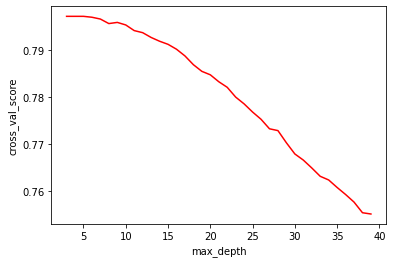

best depth: 3


In [21]:
#5-fold Cross-validation to set the depth
depth=[]
for i in range(3,40):
  clf = DecisionTreeClassifier(max_depth=i,random_state=42)
  CVscore=np.mean(cross_val_score(clf, Xtrain, ytrain, cv=5))
  depth.append(CVscore)
plt.figure()
line1, = plt.plot(list(range(3, 40)), depth, color="r", label="depth")
plt.ylabel('cross_val_score')
plt.xlabel('max_depth')

plt.show()
print("best depth:",3+depth.index(max(depth)))

[Text(1453.125, 1783.6875, 'X[7] <= 0.5\ngini = 0.323\nsamples = 88420\nvalue = [70492, 17928]'),
 Text(726.5625, 1274.0625, 'X[1] <= 20.5\ngini = 0.088\nsamples = 30851\nvalue = [29428, 1423]'),
 Text(363.28125, 764.4375, 'X[1] <= 6.5\ngini = 0.125\nsamples = 10320\nvalue = [9626, 694]'),
 Text(181.640625, 254.8125, 'gini = 0.058\nsamples = 4687\nvalue = [4546, 141]'),
 Text(544.921875, 254.8125, 'gini = 0.177\nsamples = 5633\nvalue = [5080, 553]'),
 Text(1089.84375, 764.4375, 'X[78] <= 0.5\ngini = 0.068\nsamples = 20531\nvalue = [19802, 729]'),
 Text(908.203125, 254.8125, 'gini = 0.066\nsamples = 20310\nvalue = [19620, 690]'),
 Text(1271.484375, 254.8125, 'gini = 0.291\nsamples = 221\nvalue = [182, 39]'),
 Text(2179.6875, 1274.0625, 'X[1] <= 48.5\ngini = 0.409\nsamples = 57569\nvalue = [41064, 16505]'),
 Text(1816.40625, 764.4375, 'X[7] <= 9.5\ngini = 0.439\nsamples = 36059\nvalue = [24316, 11743]'),
 Text(1634.765625, 254.8125, 'gini = 0.405\nsamples = 17009\nvalue = [12221, 4788]')

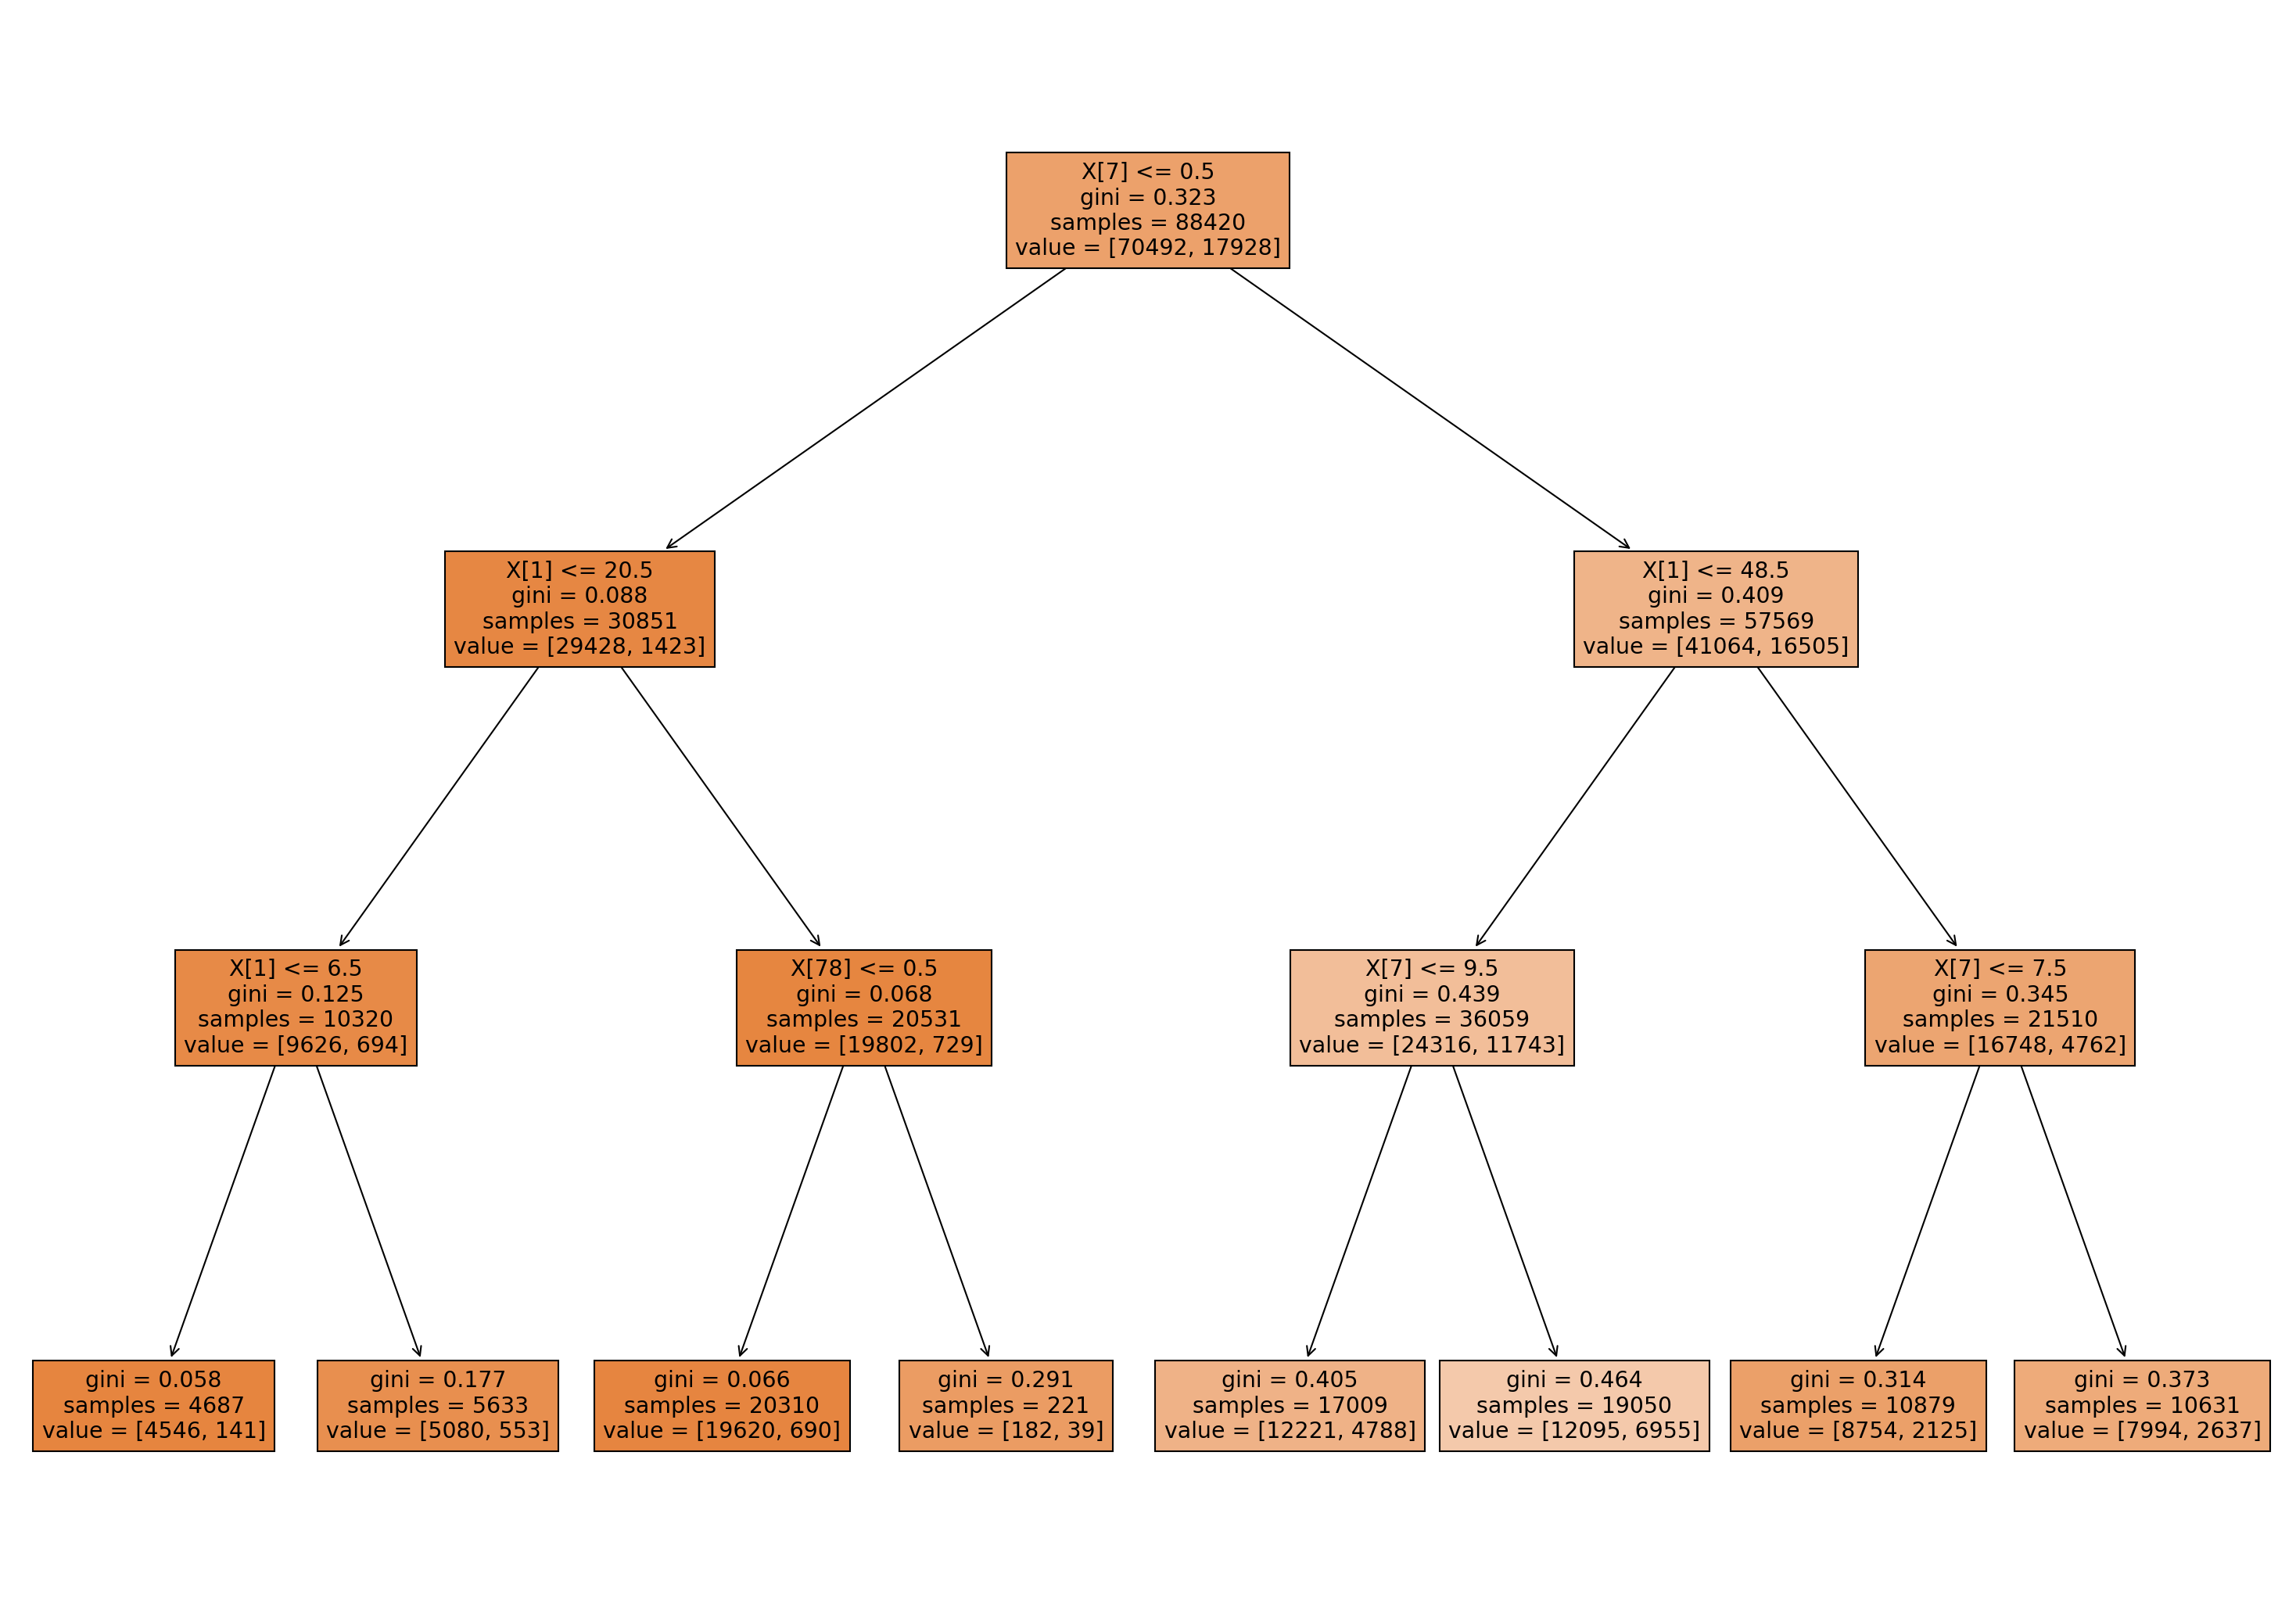

In [31]:
plt.figure( figsize=[25,18],dpi=150)
Dtree = DecisionTreeClassifier(max_depth=3,random_state=42).fit(Xtrain,ytrain)
plot_tree(Dtree,filled=True)

In [23]:
y_pred_Dtree=Dtree.predict(Xtest)
tree_accuracy=accuracy_score(ytest, y_pred_Dtree)
tree_accuracy

0.8013661449380258

##Random forest

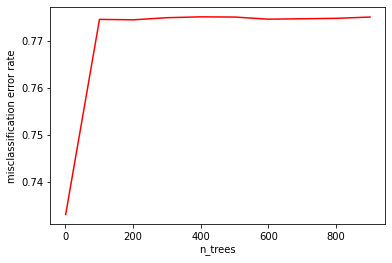

In [39]:
"""tree_list=[]
test_results = []
list_nb_trees = np.arange(1, 1000, 100).tolist()

for nb_trees in list_nb_trees:
    rf = RandomForestClassifier(n_estimators=nb_trees,random_state=42)
    y_pre_RF=rf.fit(Xtrain, ytrain).predict(Xtest)
    test_results.append(accuracy_score(ytest, y_pre_RF))
    

line1, = plt.plot(list_nb_trees, test_results, color="r", label="Randomforest")


plt.ylabel('misclassification error rate')
plt.xlabel('n_trees')
plt.show()"""

In [37]:
best_ntrees=list_nb_trees[test_results.index(max(test_results))]
best_ntrees

401

In [43]:
RF = RandomForestClassifier(n_estimators=400,random_state=42).fit(Xtrain, ytrain)




In [45]:
y_pred_RF=RF.predict(Xtest)
tree_accuracy=accuracy_score(ytest, y_pred_RF)
tree_accuracy

0.7752193974486564

94
Feature ranking:
1. feature Age (0.366109)
2. feature daystoappoint (0.350658)
3. feature Gender (0.028415)
4. feature SMS_received (0.018942)
5. feature Hipertension (0.009672)
6. feature Scholarship (0.008186)
7. feature Diabetes (0.007935)
8. feature Alcoholism (0.006141)
9. feature NB_RESISTÊNCIA (0.005235)
10. feature NB_JARDIM CAMBURI (0.004953)


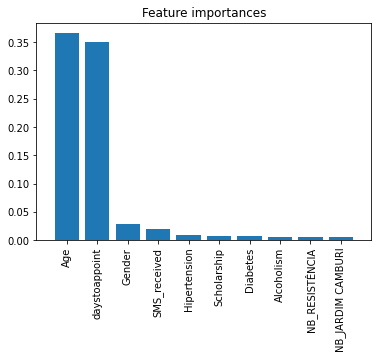

In [80]:
df_Col=list(Xtrain.columns)
importances=RF.feature_importances_
print(len(importances))
std = np.std([tree.feature_importances_ for tree in RF.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
top10=[]
for f in range(10):
  top=df_Col[indices[f]]
  print("%d. feature %s (%f)" % (f + 1, top, importances[indices[f]]))
  top10.append(top)


# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar([x for x in range(10)], importances[indices[0:10]])
plt.xticks(range(10),top10,rotation=90)
plt.xlim([-1, 10])
plt.show()
